In [1]:
# https://arxiv.org/abs/1610.02415

# https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
import torch.distributed as dist

import torch_geometric
import torch_geometric.nn as gnn
#print(torch_geometric.__version__)
from torch_geometric.datasets import QM9
import GCL.augmentors
import GCL.augmentors as A

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression, LinearRegression
import itertools

import GCL.augmentors as A
from GCL.augmentors import node_dropping, ppr_diffusion, feature_dropout, edge_adding, rw_sampling

# EdgeAdding
# EdgeRemoving
# NodeDropping
# Random Walk Sampling

# FeatureDropout
# FeatureMasking

# EdgeAttrMasking
# EdgeAttrDropout

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

1.13.1+cu117
cuda


In [2]:

parameters = {}
parameters['batch_size'] = 256 # This could be much higher - not sure what was causing memory errors earlier
parameters['n_epochs'] = 30
parameters['learning_rate'] = 0.002

In [3]:
whole_dataset = QM9(root = 'data/')


n = whole_dataset.len()
tr_n = 2000 # Number of QM9 to use as training data

all_inds = range(n)
tr_inds, val_inds = train_test_split(all_inds, train_size = tr_n)
print(len(tr_inds), len(val_inds))
print(type(tr_inds), type(tr_inds[0]))


train_sampler = torch.utils.data.SubsetRandomSampler(tr_inds)
val_sampler = torch.utils.data.SubsetRandomSampler(val_inds)

# We need to make a train and validation set since QM9 does not provide them
train_set = torch.utils.data.Subset(whole_dataset, tr_inds)
val_set = torch.utils.data.Subset(whole_dataset, val_inds)

train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = parameters['batch_size'],
                                                shuffle = True, num_workers = 2,)
                                                #sampler = train_sampler)
big_train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = 2048,
                                                shuffle = True, num_workers = 2,)

val_loader = torch_geometric.loader.DataLoader(val_set, batch_size=4096, # I am using this to get a random subset of the val set
                                            shuffle=True, num_workers=2,)
                                              #sampler = val_sampler)
    
val_aug = A.RandomChoice([], num_choices = 0)


2000 128831
<class 'list'> <class 'int'>


In [4]:
qm9_index = {0: 'Dipole moment',
1: 'Isotropic polarizability',
2: 'Highest occupied molecular orbital energy',
3: 'Lowest unoccupied molecular orbital energy',
4: 'Gap between previous 2',
5: 'Electronic spatial extent',
6: 'Zero point vibrational energy',
7: 'Internal energy at 0K',
8: 'Internal energy at 298.15K',
9: 'Enthalpy at 298.15K',
10: 'Free energy at 298.15K',
11: 'Heat capavity at 298.15K',
12: 'Atomization energy at 0K',
13: 'Atomization energy at 298.15K',
14: 'Atomization enthalpy at 298.15K',
15: 'Atomization free energy at 298.15K',
16: 'Rotational constant A',
17: 'Rotational constant B',
18: 'Rotational constant C',}

print(qm9_index.items())

dict_items([(0, 'Dipole moment'), (1, 'Isotropic polarizability'), (2, 'Highest occupied molecular orbital energy'), (3, 'Lowest unoccupied molecular orbital energy'), (4, 'Gap between previous 2'), (5, 'Electronic spatial extent'), (6, 'Zero point vibrational energy'), (7, 'Internal energy at 0K'), (8, 'Internal energy at 298.15K'), (9, 'Enthalpy at 298.15K'), (10, 'Free energy at 298.15K'), (11, 'Heat capavity at 298.15K'), (12, 'Atomization energy at 0K'), (13, 'Atomization energy at 298.15K'), (14, 'Atomization enthalpy at 298.15K'), (15, 'Atomization free energy at 298.15K'), (16, 'Rotational constant A'), (17, 'Rotational constant B'), (18, 'Rotational constant C')])


In [5]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Graph 2
        self.conv3 = GCNConv(self.rep_dim, self.rep_dim * 2) # To Emb Space
        self.bn3 = nn.BatchNorm1d(self.rep_dim * 2)
        
        # Projection to embedding
        #self.mpool2 = gnn.global_mean_pool
        #self.fc2 = nn.Linear(self.emb_dim, self.emb_dim) # Linear to rep?
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        x_rep = self.mpool1(x, binds)
        
        x_emb = self.conv3(x, edge_index)
        return x_rep, x_emb

## Here is my proposal for a neural network baseline, which is trained in a supervised manner
# But maintains the same architecture as the VicReg model.
# It could be trained to predict 19 outputs, or 1, or some amount.
# Then you could transfer it to other outputs with transfer learning technique (new head)
class Supervised_GCN_Equivalent(torch.nn.Module):
    def __init__(self, c_dim):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        self.c_dim = 19
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Projection to embedding
        self.fc2 = nn.Linear(self.rep_dim, self.c_dim) # Linear to rep?
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        x_rep = self.mpool1(x, binds)
        yhat = self.fc2(x_rep)
        
        return yhat

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

def VicRegLoss(x, y):
    # https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#L184
    # x, y are output of projector(backbone(x and y))
    
    # These are the default params used in natural image vicreg
    sim_coeff = 25
    std_coeff = 25
    cov_coeff = 1
    
    
    repr_loss = F.mse_loss(x, y)

    x = x - x.mean(dim=0)
    y = y - y.mean(dim=0)

    std_x = torch.sqrt(x.var(dim=0) + 0.0001)
    std_y = torch.sqrt(y.var(dim=0) + 0.0001)
    std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

    cov_x = (x.T @ x) / (parameters['batch_size'] - 1)
    cov_y = (y.T @ y) / (parameters['batch_size'] - 1)
    cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
        x.shape[1]
    ) + off_diagonal(cov_y).pow_(2).sum().div(x.shape[1])
    
    # self.num_features -> rep_dim?
    loss = (
        sim_coeff * repr_loss
        + std_coeff * std_loss
        + cov_coeff * cov_loss
    )
    return loss


def train(parameters):
    
    device = 'cuda'

    model = GCN().to(device)
    n_epochs = parameters['n_epochs']
    aug = parameters['augmentation']
    
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=5e-4)

    tr_losses = []
    val_losses = []

    for epoch in range(0,n_epochs+1):
        epoch_losses = []
        for batch in train_loader:
            optimizer.zero_grad()

            batch_inds = batch.batch.to(device)

            # batch of graphs has edge attribs, node attribs - (n_nodes, n_features+1) -> concat (n_nodes, attrib1)
            batch.x = batch.x.float()#.to(device)

            # Barlow - get 2 random views of batch
            b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
            b2 = aug(batch.x, batch.edge_index, batch.edge_attr)

            # Embed each batch (ignoring representations)
            r1, e1 = model(b1, batch_inds)
            r2, e2 = model(b2, batch_inds)

            loss = VicRegLoss(e1, e2)
            loss.backward()
            optimizer.step()

            #epoch_losses.append(loss.data.item())

        #print('epoch train loss', sum(epoch_losses) / len(epoch_losses))
        #tr_losses.append(sum(epoch_losses) / len(epoch_losses))
        
        # VicReg Validation Loss
        if True:
            val_loss = []
            for batch in val_loader:
                with torch.no_grad():
                    # VicReg validation loss
                    b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
                    b2 = aug(batch.x, batch.edge_index, batch.edge_attr)
                    r1, e1 = model(b1, batch.batch.to(device))
                    r2, e2 = model(b2, batch.batch.to(device))

                    val_loss.append(VicRegLoss(e1, e2).item())

            val_losses.append(torch.mean(torch.FloatTensor(val_loss)))
    
    return model, tr_losses, val_losses

def test(model, big_train_loader, val_loader, parameters):
    # Downstream supervised loss      
    scores = []
    for batch in big_train_loader: # take entire train set
        with torch.no_grad():
            # Embed training set under model
            rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))

            for i, val_batch in enumerate(val_loader):
                print('doing a batch')
                # Embed validation set under model
                rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))

                # For each task in QM9
                for tar_ind in range(batch.y.shape[1]):
                    # Fit a model on model representation of train set
                    lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
                    # Test the model on model repersentation of val set
                    tar_yhat = lm.predict(rep_val.cpu())
                    mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
                    r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                    scores.append(mse_met)
                    
                if i==0:
                    break # Only want first batch, please
                    
    return scores

import os
def trymkdir(path):
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)

In [ ]:
def train_supervised(parameters):
    
    # Get target types from parameters - one task or 19?
    task = parameters['task'] # An index for which task the model is trained on - or 'all'
    
    if task == 'all':
        task_index = [0:]
    else:
        task_index = [task:task+1]
    
    device = 'cuda'
    model = Supervised_GCN_Equivalent(c_dim = 19).to(device)
    
    mse_loss = torch.nn.MSELoss()
    n_epochs = parameters['n_epochs']
    
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=5e-4)

    tr_losses = []
    val_losses = []

    for epoch in range(0,n_epochs+1):
        epoch_losses = []
        for batch in train_loader:
            optimizer.zero_grad()

            batch_inds = batch.batch.to(device)
            
            # batch of graphs has edge attribs, node attribs - (n_nodes, n_features+1) -> concat (n_nodes, attrib1)
            batch.x = batch.x.float()#.to(device)

            # Augment batch?
            #batch = aug(batch.x, batch.edge_index, batch.edge_attr)

            # Embed each batch (ignoring representations)
            yhat = model([batch.x, batch.edge_index, batch.edge_attr], batch_inds)
            
            #print(yhat, type(yhat), yhat[0].shape)
            loss = mse_loss(yhat, batch.y[task_index].to(device))
            loss.backward()
            optimizer.step()
            print(loss.data.item())
            
            epoch_losses.append(loss.data.item())
            
        # test the model
        supervised_los  = def()
        print('Epoch loss: ', round(sum(epoch_losses) / len(epoch_losses), 2))

if False:
    train_supervised(parameters)

In [7]:
# # This study is on the effect of the NUMBER of augmentations

# # For N trials:

# # Sample N random augmentations from auglist (without replacement!)

# # Train, validate with that model

# # Assemble results given n augmentations

# # For 1,...,k augmentations:
# augs = [A.RWSampling(num_seeds=1000, walk_length=10),
#         A.EdgeAttrmasking(),
#         A.MarkovDiffusion(),
#         A.NodeDropping(pn=0.1),
#         #A.EdgeAdding(pe=0.1),
#         A.FeatureMasking(pf=0.1),
#         A.EdgeRemoving(pe=0.1)]

# parameters['n_epochs'] = 1
# auglist = []
# for i, aug in enumerate(augs):
#     # Design an augmentation
#     auglist.append(aug)
#     print(auglist)
#     augmentation = A.RandomChoice(auglist, num_choices=1)
    
#     # Train with that augmentation
#     parameters['augmentation'] = augmentation
#     model, tr_losses, val_losses = train(parameters)
    
#     # Test with that augmentation
#     scores = test(model, big_train_loader, val_loader, parameters)
    
#     # Visualize validation loss
#     plt.plot(val_losses, label = f'Augmentation Set Length {i}')
    
#     # Print some scores
#     print('Validation set Dipole Moment MSE: ', scores[0])
    
#     torch.save(aug, f'aug_sweep1234/aug_{i}.pt')
#     torch.save(scores, f'aug_sweep1234/scores_{i}.pt')
#     print(scores)

In [46]:
# This study:
# For n trials, randomly sample a length of aug_n augmentations from the list
# Train a vicreg on that augmentation composition
# test the vicreg
# assemble the results based on the LENGRH of augmentations

import random

n_trials = 40
max_augs = 6

augs = [A.RWSampling(num_seeds=1000, walk_length=10),
        #A.EdgeAttrMasking(pf=0.1),
        #A.MarkovDiffusion(),
        A.NodeDropping(pn=0.1),
        A.NodeShuffling(),
        #A.EdgeAdding(pe=0.1),
        A.FeatureMasking(pf=0.1),
        A.FeatureDropout(pf=0.1),
        A.EdgeRemoving(pe=0.1)]

parameters['n_epochs'] = 5

#colors = ['red', 'blue', 'green', 'black', 'yellow']

for aug_n in range(1, max_augs+1):
    
    for trial in range(n_trials):
        print(f'Augmentation length {aug_n} - trial {trial}')
        
        if os.path.isfile(f'aug_sweep1234/scores_{aug_n}_{trial}.pt'):
            print('Experiment exists, continue')
            val_losses = torch.load(f'aug_sweep1234/val_{aug_n}_{trial}.pt')
            #plt.plot(val_losses, label = f'Augmentation Set Length {aug_n}', color = colors[aug_n-1])
        else:

            augmentation_list = random.sample(augs, aug_n)
            print(augmentation_list)
            augmentation = A.RandomChoice(augmentation_list, num_choices=1)

            # Train with that augmentation
            parameters['augmentation'] = augmentation
            model, tr_losses, val_losses = train(parameters)

            # Test with that augmentation
            scores = test(model, big_train_loader, val_loader, parameters)

            # Visualize validation loss
            #plt.plot(val_losses, label = f'Augmentation Set Length {aug_n}', color = colors[aug_n-1])

            # Print some scores
            print('Validation set Dipole Moment MSE: ', scores[0])

            torch.save(tr_losses, f'aug_sweep1234/tr_{aug_n}_{trial}.pt') # save the training scores
            torch.save(val_losses, f'aug_sweep1234/val_{aug_n}_{trial}.pt') # save the validation scores
            torch.save(augmentation_list, f'aug_sweep1234/aug_{aug_n}_{trial}.pt') # save the augmentation
            torch.save(scores, f'aug_sweep1234/scores_{aug_n}_{trial}.pt') # save the scores
        
#plt.legend(loc = 'best')
#plt.xlabel('Training iterations')
#plt.ylabel('VicReg Validation Losses')
#plt.show()

Augmentation length 1 - trial 0
Experiment exists, continue
Augmentation length 1 - trial 1
Experiment exists, continue
Augmentation length 1 - trial 2
Experiment exists, continue
Augmentation length 1 - trial 3
Experiment exists, continue
Augmentation length 1 - trial 4
Experiment exists, continue
Augmentation length 1 - trial 5
Experiment exists, continue
Augmentation length 1 - trial 6
Experiment exists, continue
Augmentation length 1 - trial 7
Experiment exists, continue
Augmentation length 1 - trial 8
Experiment exists, continue
Augmentation length 1 - trial 9
Experiment exists, continue
Augmentation length 1 - trial 10
Experiment exists, continue
Augmentation length 1 - trial 11
Experiment exists, continue
Augmentation length 1 - trial 12
Experiment exists, continue
Augmentation length 1 - trial 13
Experiment exists, continue
Augmentation length 1 - trial 14
Experiment exists, continue
Augmentation length 1 - trial 15
Experiment exists, continue
Augmentation length 1 - trial 16
E

C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  16.572891235351562
Augmentation length 1 - trial 35
doing a batch
Validation set Dipole Moment MSE:  14.261868476867676
Augmentation length 1 - trial 36
doing a batch
Validation set Dipole Moment MSE:  670.7408447265625
Augmentation length 1 - trial 37
doing a batch
Validation set Dipole Moment MSE:  2020.1695556640625
Augmentation length 1 - trial 38
doing a batch
Validation set Dipole Moment MSE:  142.75
Augmentation length 1 - trial 39
doing a batch
Validation set Dipole Moment MSE:  5962.642578125
Augmentation length 2 - trial 0
Experiment exists, continue
Augmentation length 2 - trial 1
Experiment exists, continue
Augmentation length 2 - trial 2
Experiment exists, continue
Augmentation length 2 - trial 3
Experiment exists, continue
Augmentation length 2 - trial 4
Experiment exists, continue
Augmentation length 2 - trial 5
Experiment exists, continue
Augmentation length 2 - trial 6
Experiment exists, continue
Augmentation length 2 - 

C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  662.8447265625
Augmentation length 2 - trial 33
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]
doing a batch
Validation set Dipole Moment MSE:  44.58866882324219
Augmentation length 2 - trial 34
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]
doing a batch
Validation set Dipole Moment MSE:  60.8031005859375
Augmentation length 2 - trial 35
[<GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]
doing a batch
Validation set Dipole Moment MSE:  100.9453125
Augmentation length 2 - trial 36
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x000001276

C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  15.226531028747559
Augmentation length 3 - trial 0
Experiment exists, continue
Augmentation length 3 - trial 1
Experiment exists, continue
Augmentation length 3 - trial 2
Experiment exists, continue
Augmentation length 3 - trial 3
Experiment exists, continue
Augmentation length 3 - trial 4
Experiment exists, continue
Augmentation length 3 - trial 5
Experiment exists, continue
Augmentation length 3 - trial 6
Experiment exists, continue
Augmentation length 3 - trial 7
Experiment exists, continue
Augmentation length 3 - trial 8
Experiment exists, continue
Augmentation length 3 - trial 9
Experiment exists, continue
Augmentation length 3 - trial 10
Experiment exists, continue
Augmentation length 3 - trial 11
Experiment exists, continue
Augmentation length 3 - trial 12
Experiment exists, continue
Augmentation length 3 - trial 13
Experiment exists, continue
Augmentation length 3 - trial 14
Experiment exists, continue
Augmentation length 3 - tri

C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  495.5212707519531
Augmentation length 3 - trial 21
[<GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]
doing a batch
Validation set Dipole Moment MSE:  433.9380187988281
Augmentation length 3 - trial 22
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>]
doing a batch
Validation set Dipole Moment MSE:  11022.748046875
Augmentation length 3 - trial 23
[<GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  33.23838424682617
Augmentation length 3 - trial 24
[<GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>]
doing a batch
Validation set Dipole Moment MSE:  86.73653411865234
Augmentation length 3 - trial 25
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  44715.48828125
Augmentation length 3 - trial 26
[<GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  236.78076171875
Augmentation length 3 - trial 27
[<GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  8417.517578125
Augmentation length 3 - trial 28
[<GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  15858.875
Augmentation length 3 - trial 29
[<GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]
doing a batch
Validation set Dipole Moment MSE:  23602.1328125
Augmentation length 3 - trial 30
[<GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  10030.2470703125
Augmentation length 3 - trial 31
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  45.19569396972656
Augmentation length 3 - trial 32
[<GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>]
doing a batch
Validation set Dipole Moment MSE:  36458.3203125
Augmentation length 3 - trial 33
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]
doing a batch
Validation set Dipole Moment MSE:  26522.0078125
Augmentation length 3 - trial 34
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]
doing a batch
Validation set Dipole M

C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  15132.6416015625
Augmentation length 3 - trial 36
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  234.54209899902344
Augmentation length 3 - trial 37
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]
doing a batch
Validation set Dipole Moment MSE:  3606.866455078125
Augmentation length 3 - trial 38
[<GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]
doing a batch
Validation set Dipole Moment MSE:  112.37883758544922
Augmentation length 3 - trial 39
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>]
doing a batch
V

C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  29.0107421875
Augmentation length 4 - trial 22
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  21.75106430053711
Augmentation length 4 - trial 23
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  429.6326904296875
Augmentation length 4 - trial 24
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  28.447004318237305
Augmentation length 4 - trial 25
[<GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  212.83302307128906
Augmentation length 4 - trial 26
[<GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  7705.8349609375
Augmentation length 4 - trial 27
[<GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  99.28496551513672
Augmentation length 4 - trial 28
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  204.33535766601562
Augmentation length 4 - trial 29
[<GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>]
doing a batch
Validation set Dipole Moment MSE:  3.901118278503418
Augmentation length 4 - trial 30
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]
doing a batch
Validation set Dipole Moment MSE:  12.443535804748535
Augmentation length 4 - trial 31
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature

C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  16228.482421875
Augmentation length 4 - trial 33
[<GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  34930.3359375
Augmentation length 4 - trial 34
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  38602.21875
Augmentation length 4 - trial 35
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  536.458984375
Augmentation length 4 - trial 36
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  265.1117248535156
Augmentation length 4 - trial 37
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  180.36048889160156
Augmentation length 4 - trial 38
[<GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]
doing a batch
Validation set Dipole Moment MSE:  162.16285705566406
Augmentation length 4 - trial 39
[<GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  2863.50390625
Augmentation length 5 - trial 0
Experiment exists, continue
Augmentation length 5 - trial 1
Experiment exists, continue
Augmentation length 5 - trial 2
Experiment exists, continue
Augmentation length 5 - trial 3
Experiment exists, continue
Augmentation length 5 - trial 4
Experiment exists, continue
Augmentation length 5 - trial 5
Experiment exists, continue
Augmentation length 5 - trial 6
Experiment exists, continue
Augmentation length 5 - trial 7
Experiment exists, continue
Augmentation length 5 - trial 8
Experiment exists, continue
Augmentation length 5 - trial 9
Experiment exists, continue
Augmentation length 5 - trial 10
Experiment exists, continue
Augmentation length 5 - trial 11
Experiment exists, continue
Augmentation length 5 - trial 12
Experiment exists, continue
Augmentation length 5 - trial 13
Experiment exists, continue
Augmentation length 5 - trial 14
Experiment exists, continue
Augmentation length 5 - trial 15

C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  19632.34375
Augmentation length 5 - trial 21
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  13733.6103515625
Augmentation length 5 - trial 22
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  285.91461181640625
Augmentation length 5 - trial 23
[<GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>]
doing a batch
Validation set Dipole Moment MSE:  561.264404296875
Augmentation length 5 - trial 24
[<GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  329.5631103515625
Augmentation length 5 - trial 25
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  3.625983953475952
Augmentation length 5 - trial 26
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>]
doing a batch
Validation set Dipole Moment MSE:  2099.101318359375
Augmentation length 5 - trial 27
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  29.595447540283203
Augmentation length 5 - trial 28
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  33943.3515625
Augmentation length 5 - trial 29
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  23752.53515625
Augmentation length 5 - trial 30
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  128.81443786621094
Augmentation length 5 - trial 31
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  24.78551483154297
Augmentation length 5 - trial 32
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  1060.66943359375
Augmentation length 5 - trial 33
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  469.13006591796875
Augmentation length 5 - trial 34
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]
doing a batch
Validation set Dipole Moment MSE:  25766.15234375
Augmentation length 5 - trial 35
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  798.3810424804688
Augmentation length 5 - trial 36
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  8.872479438781738
Augmentation length 5 - trial 37
[<GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  17419.544921875
Augmentation length 5 - trial 38
[<GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  303.22601318359375
Augmentation length 5 - trial 39
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  124.89352416992188
Augmentation length 6 - trial 0
Experiment exists, continue
Augmentation length 6 - trial 1
Experiment exists, continue
Augmentation length 6 - trial 2
Experiment exists, continue
Augmentation length 6 - trial 3
Experiment exists, continue
Augmentation length 6 - trial 4
Experiment exists, continue
Augmentation length 6 - trial 5
Experiment exists, continue
Augmentation length 6 - trial 6
Experiment exists, continue
Augmentation length 6 - trial 7
Experiment exists, continue
Augmentation length 6 - trial 8
Experiment exists, continue
Augmentation length 6 - trial 9
Experiment exists, continue
Augmentation length 6 - trial 10
Experiment exists, continue
Augmentation length 6 - trial 11
Experiment exists, continue
Augmentation length 6 - trial 12
Experiment exists, continue
Augmentation length 6 - trial 13
Experiment exists, continue
Augmentation length 6 - trial 14
Experiment exists, continue
Augmentation length 6 - tri

C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  607.3563232421875
Augmentation length 6 - trial 21
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  1250.529052734375
Augmentation length 6 - trial 22
[<GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  343.76092529296875
Augmentation length 6 - trial 23
[<GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  48.093406677246094
Augmentation length 6 - trial 24
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  9.15914535522461
Augmentation length 6 - trial 25
[<GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  11.880926132202148
Augmentation length 6 - trial 26
[<GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  39.861236572265625
Augmentation length 6 - trial 27
[<GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  66193.2734375
Augmentation length 6 - trial 28
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  386.754638671875
Augmentation length 6 - trial 29
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  10181.6728515625
Augmentation length 6 - trial 30
[<GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  65864.234375
Augmentation length 6 - trial 31
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  13844.375
Augmentation length 6 - trial 32
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  22287.625
Augmentation length 6 - trial 33
[<GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  686.4188232421875
Augmentation length 6 - trial 34
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  1.9088313579559326
Augmentation length 6 - trial 35
[<GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  2.0783286094665527
Augmentation length 6 - trial 36
[<GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  152.71066284179688
Augmentation length 6 - trial 37
[<GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  381.7748718261719
Augmentation length 6 - trial 38
[<GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  161.90560913085938
Augmentation length 6 - trial 39
[<GCL.augmentors.feature_dropout.FeatureDropout object at 0x0000012766E75CC0>, <GCL.augmentors.node_shuffling.NodeShuffling object at 0x0000012766EE7CD0>, <GCL.augmentors.rw_sampling.RWSampling object at 0x0000012766EE6920>, <GCL.augmentors.edge_removing.EdgeRemoving object at 0x0000012766E77B80>, <GCL.augmentors.feature_masking.FeatureMasking object at 0x0000012766E774C0>, <GCL.augmentors.node_dropping.NodeDropping object at 0x0000012766EE4CD0>]


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


doing a batch
Validation set Dipole Moment MSE:  8235.0166015625


Saving to imgs/n_augs_test/Dipole moment_n_augs_multitrial.png


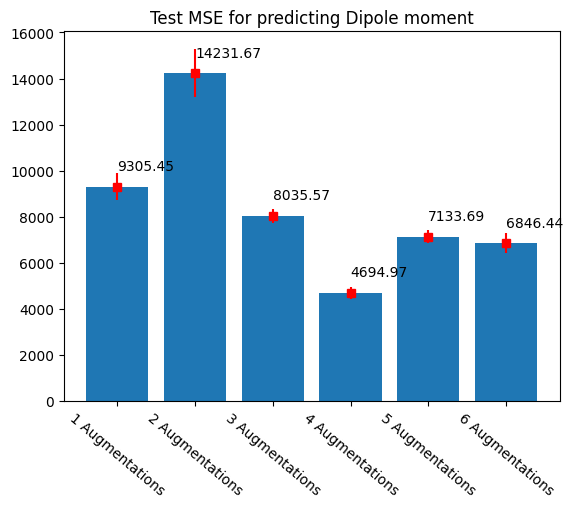

Saving to imgs/n_augs_test/Isotropic polarizability_n_augs_multitrial.png


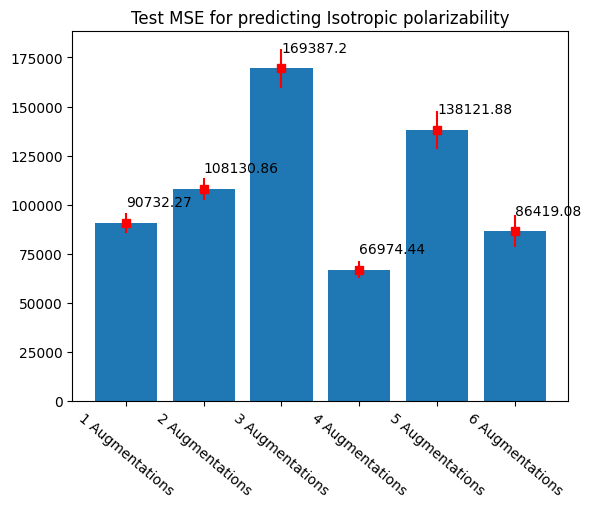

Saving to imgs/n_augs_test/Highest occupied molecular orbital energy_n_augs_multitrial.png


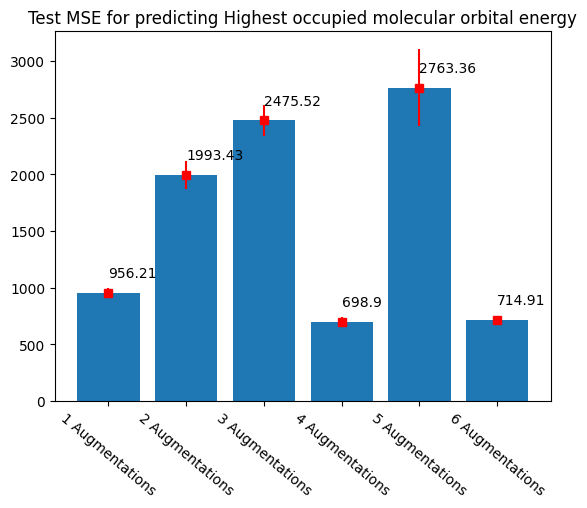

Saving to imgs/n_augs_test/Lowest unoccupied molecular orbital energy_n_augs_multitrial.png


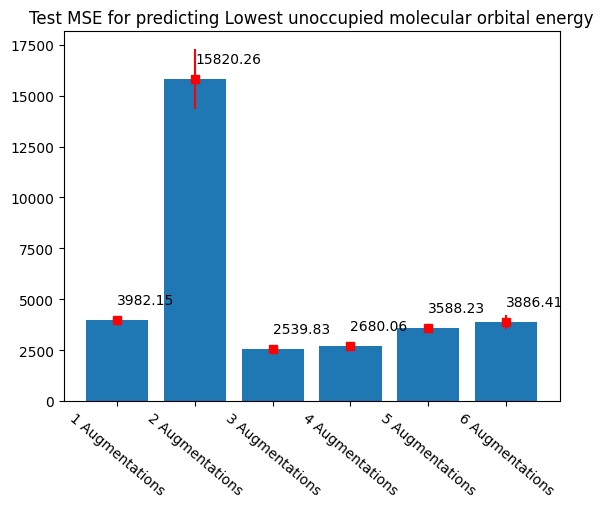

Saving to imgs/n_augs_test/Gap between previous 2_n_augs_multitrial.png


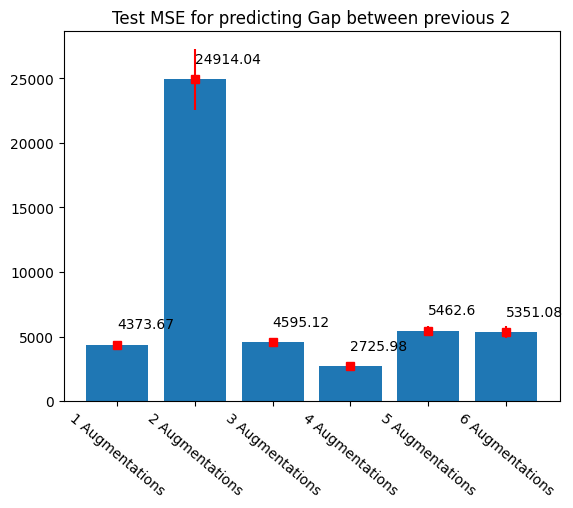

Saving to imgs/n_augs_test/Electronic spatial extent_n_augs_multitrial.png


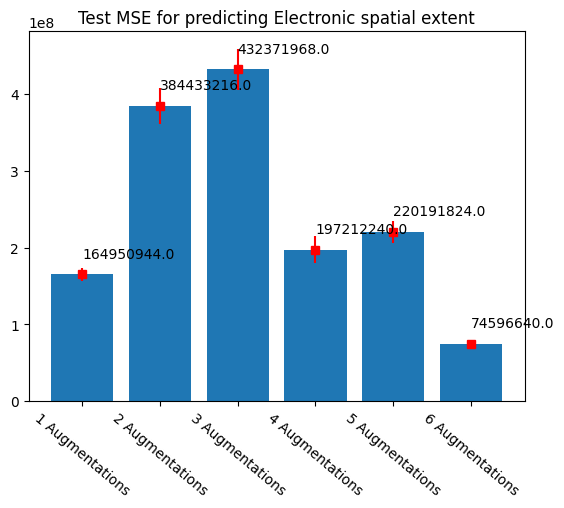

Saving to imgs/n_augs_test/Zero point vibrational energy_n_augs_multitrial.png


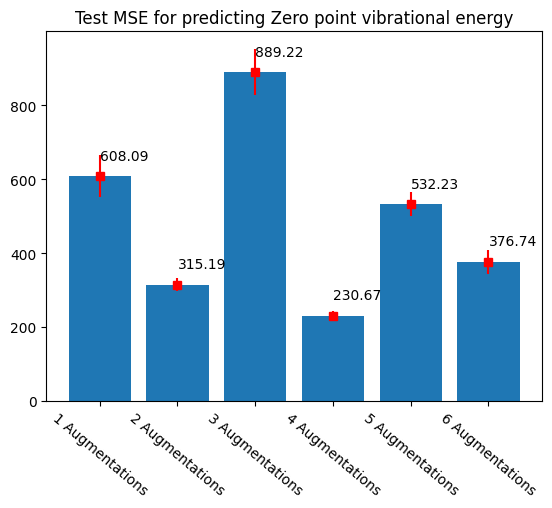

Saving to imgs/n_augs_test/Internal energy at 0K_n_augs_multitrial.png


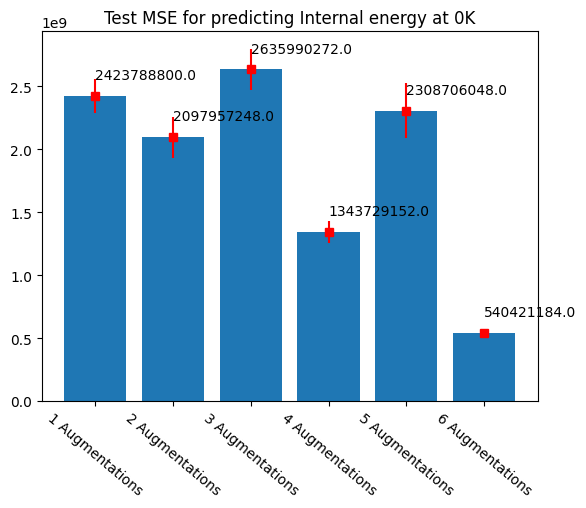

Saving to imgs/n_augs_test/Internal energy at 298.15K_n_augs_multitrial.png


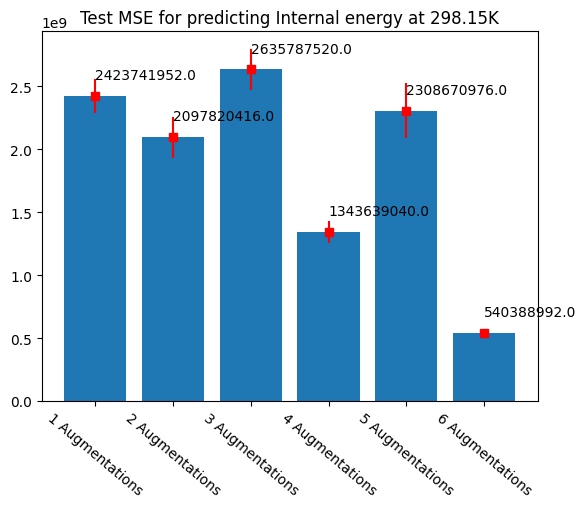

Saving to imgs/n_augs_test/Enthalpy at 298.15K_n_augs_multitrial.png


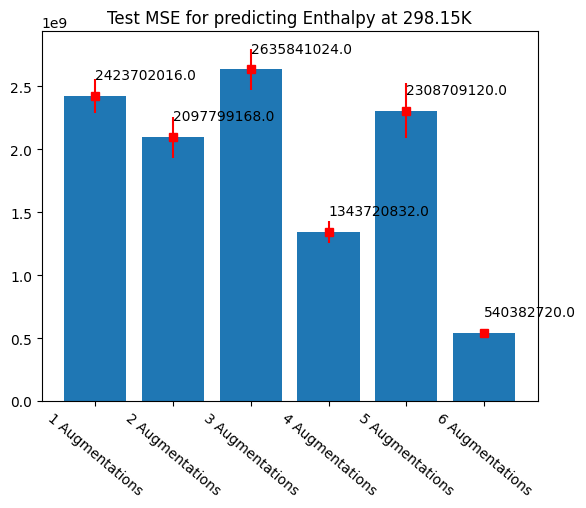

Saving to imgs/n_augs_test/Free energy at 298.15K_n_augs_multitrial.png


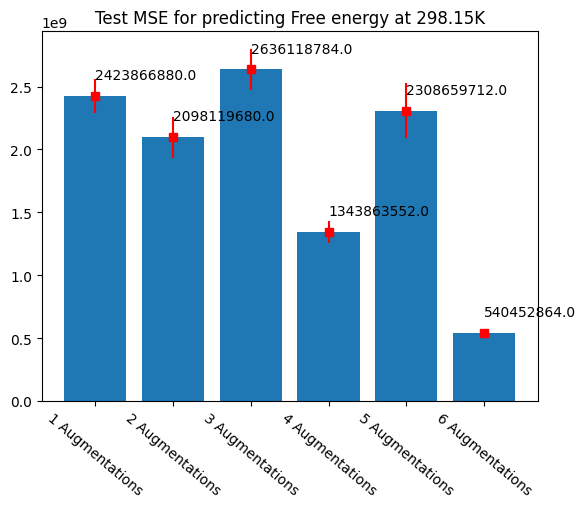

Saving to imgs/n_augs_test/Heat capavity at 298.15K_n_augs_multitrial.png


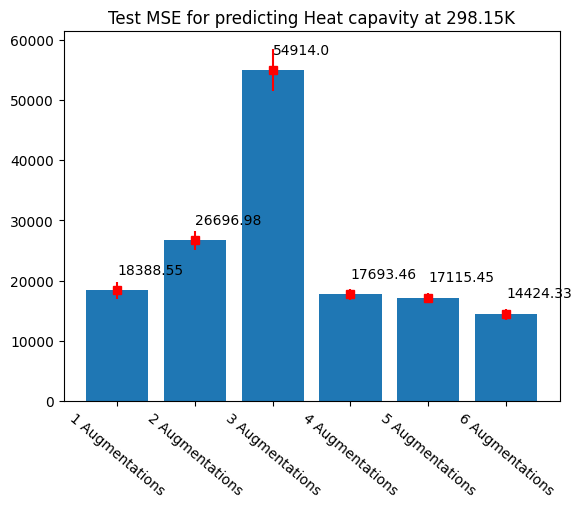

Saving to imgs/n_augs_test/Atomization energy at 0K_n_augs_multitrial.png


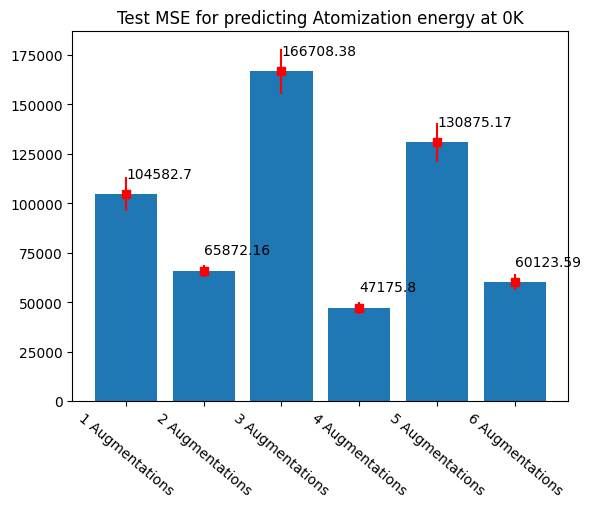

Saving to imgs/n_augs_test/Atomization energy at 298.15K_n_augs_multitrial.png


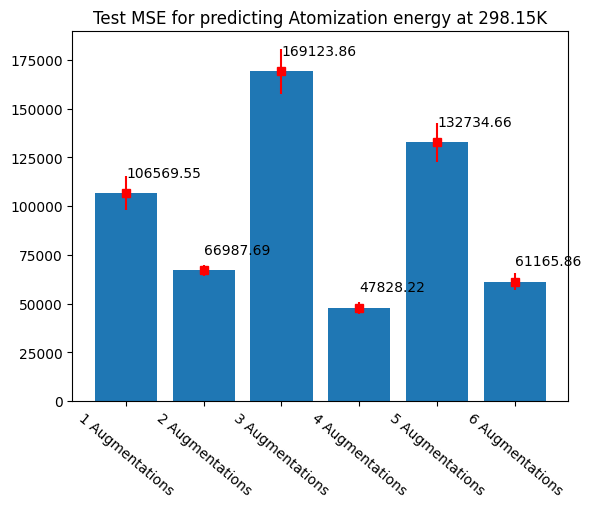

Saving to imgs/n_augs_test/Atomization enthalpy at 298.15K_n_augs_multitrial.png


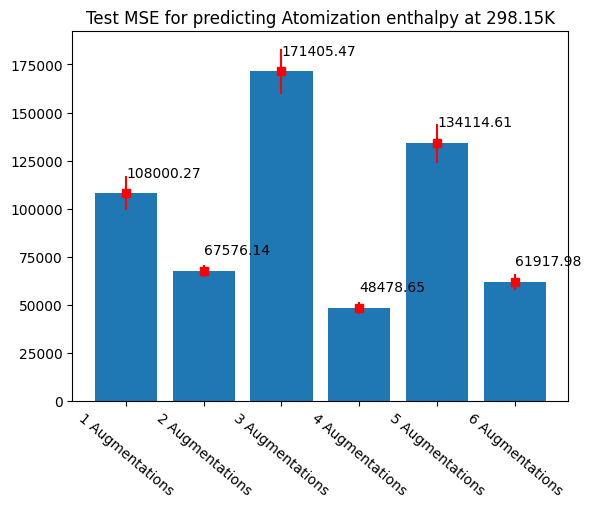

Saving to imgs/n_augs_test/Atomization free energy at 298.15K_n_augs_multitrial.png


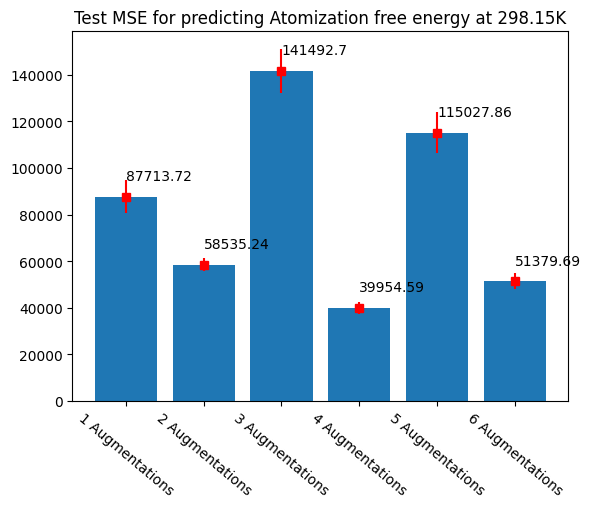

Saving to imgs/n_augs_test/Rotational constant A_n_augs_multitrial.png


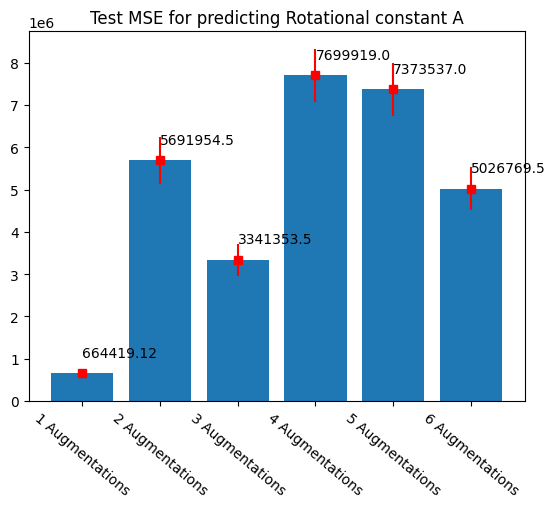

Saving to imgs/n_augs_test/Rotational constant B_n_augs_multitrial.png


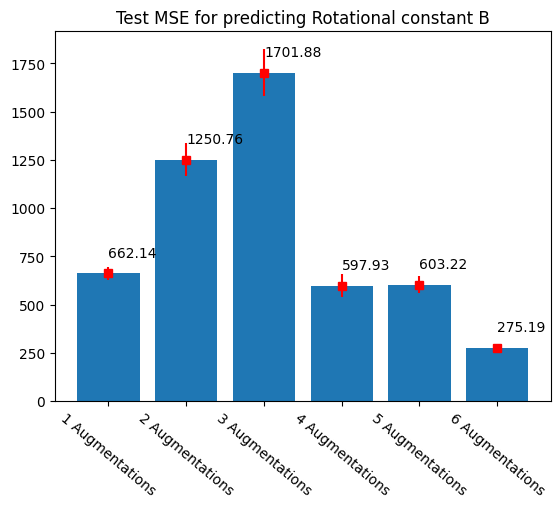

Saving to imgs/n_augs_test/Rotational constant C_n_augs_multitrial.png


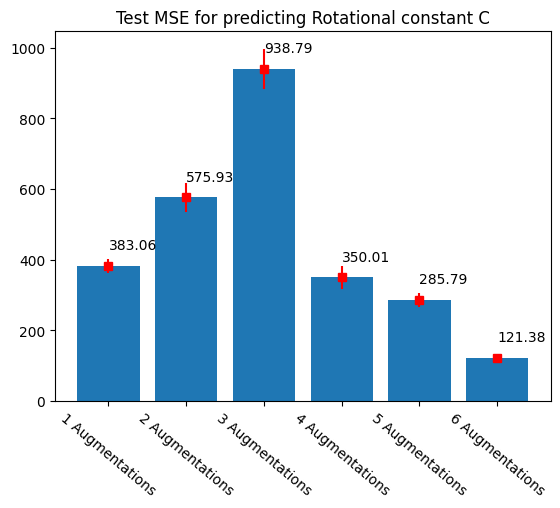

NameError: name 'breaker' is not defined

In [48]:
# Subset selection techniques for set of n augmentations:

# 'best' would be running all 2^n permutations

# 'forward' would mean doing n^2: first n, consdier second n, ..., n times
# 'backward' same number

# Iterate over the data files to load them, build a score tensor

# For each downstream, show a bar plot of the relative performances of 1,2,3,4 augmentations

mat = torch.zeros((max_augs, n_trials, 19))

for aug_n in range(1, max_augs+1):
    
    for trial in range(n_trials):

        tr_losses = torch.load(f'aug_sweep1234/tr_{aug_n}_{trial}.pt') # save the training scores
        val_losses = torch.load(f'aug_sweep1234/val_{aug_n}_{trial}.pt') # save the validation scores
        augmentation_list = torch.load(f'aug_sweep1234/aug_{aug_n}_{trial}.pt') # save the augmentation
        scores = torch.load(f'aug_sweep1234/scores_{aug_n}_{trial}.pt') # save the scores
        #print(len(scores))
        
        for i, score in enumerate(scores):
            mat[aug_n-1, trial, i] = score
            
mat = mat.permute(2,0,1) # to: task, n_aug, trials

for i, row in enumerate(mat):
    #print(row.shape)
    means = torch.mean(row, dim = 1)
    sders = torch.std(row, dim = 1) / n_trials
    
    #print(means.shape, sds.shape)
    x = range(means.shape[0])
    
    # Bars
    plt.bar(x, means)
    
    # Errorbars
    plt.errorbar(x, means, yerr = sders, fmt = 's', color = 'red')
    
    # Annotate
    for j, val in enumerate(means):
        plt.annotate(round(val.item(), 2), (j, val + 0.05*max(means)))
    
    plt.xticks(x, [str(x+1)+' Augmentations' for x in range(means.shape[0])], rotation = -40)
    plt.title(f'Test MSE for predicting {qm9_index[i]}')
    
    #plt.ylim(0,torch.mean(means))
    
    print('Saving to', f'imgs/n_augs_test/{qm9_index[i]}_n_augs_multitrial.png')
    plt.savefig(f'imgs/n_augs_test/{qm9_index[i]}_n_augs_multitrial.png', bbox_inches = 'tight')
    plt.savefig(f'imgs/n_augs_test/{qm9_index[i]}_n_augs_multitrial.pdf', bbox_inches = 'tight')
    plt.show()

print(breaker)

In [ ]:
# Turn the previous set of plots into ranks, and make a rank plot as well as a critical difference plot




In [ ]:
# Load the resuls and say if including an augmentation is good or not


# Iterate over augmentations:
for aug in augs:
    print('may need to split this nasty string thing to get the augmentation name back out', aug)
    
    belongs = []
    didnts = []
    # iterate over the saved scores:
    for aug_n in range(1, max_augs + 1):
        
        for trial in range(n_trials):
        # Get the scores for this iteration:
        scores = torch.load(f'aug_sweep1234/scores_{aug_n}_{trial}.pt')
        print('scores tensor', scores.shape)
        augmentation_list = torch.load(f'aug_sweep1234/aug_{aug_n}_{trial}.pt')
        
        # Did the current augmentation belong: if so append to belongs
        if aug in augmentation_list:
            belongs.append(scores)
            
        # if not append to didnts
        else:
            didnts.append(scores)
            
    belongs = torch.stack(belongs, dim = 0)
    didnts = torch.stack(didnts, dim = 0)
    print('For augmentation', aug, 'got scores', belongs.shape, didnts.shape)

In [ ]:
# Here is sample code for how to implement an "ablation" of 2-at-a-time augmentations
import GCL.augmentors as A
from GCL.augmentors import node_dropping, ppr_diffusion, feature_dropout, edge_adding, rw_sampling

aug = A.RandomChoice([#A.RWSampling(num_seeds=1000, walk_length=10),
                      A.NodeDropping(pn=0.1),
                      A.FeatureMasking(pf=0.1),
                      A.EdgeRemoving(pe=0.1)],
                     num_choices=1)

print(aug, type(aug))

# From a set of augmentations of length n_augmentations
aug_set = [A.NodeDropping(pn=0.1), A.FeatureMasking(pf=0.1), A.EdgeRemoving(pe=0.1), A.EdgeAdding(pe=0.1)]
           #ppr_diffusion, feature_dropout, edge_adding, rw_sampling]
    #A.PPRDiffusion()
aug_strs = ['NodeDropping', 'FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
print(aug_strs)

# First get all pairs of indexes on-off in a list of length n_augmentations
aug_inds = list(itertools.product([0, 1], repeat=len(aug_set)))
aug_inds = [x for x in aug_inds if sum(x)==1]
print(aug_inds)

# Then for each augmentation, train and test a VicReg model trained under that augment
parameters = {}
parameters['batch_size'] = 64
parameters['learning_rate'] = 0.002
# etc parameters here which define model, hparams

for aug_index in aug_inds:

    tr_augs = []
    tr_strs = []
    for ind, augi in enumerate(aug_index):
        if augi == 1:
            tr_augs.append(aug_set[ind])
            tr_strs.append(aug_strs[ind])
            
    print(tr_strs)
    trymkdir(f'aug_sweep1/{tr_strs[0]}')
    
    tr_aug = A.RandomChoice(tr_augs, num_choices = 1)
    
    #print(tr_aug, type(tr_aug))
    parameters['train_aug'] = tr_aug
    parameters['aug_str'] = tr_strs
    
    model, train_loss, val_loss, transfer_mat = train(parameters)
    #transfer_scores = transfer_score(model, parameters)
    
    #print(transfer_mat)
    torch.save(model.state_dict(), f'aug_sweep1/{tr_strs[0]}/model.pt')
    torch.save(train_loss,  f'aug_sweep1/{tr_strs[0]}/train_loss.pt')
    torch.save(val_loss,  f'aug_sweep1/{tr_strs[0]}/val_loss.pt')
    torch.save(transfer_mat,  f'aug_sweep1/{tr_strs[0]}/transfer_mat.pt')
    
plt.legend()
plt.show()
    

In [ ]:
# Here is sample code for how to implement an "ablation" of 2-at-a-time augmentations


# From a set of augmentations of length n_augmentations
aug_set = [A.NodeDropping(pn=0.1), A.FeatureMasking(pf=0.1), A.EdgeRemoving(pe=0.1), A.EdgeAdding(pe=0.1)]
           #ppr_diffusion, feature_dropout, edge_adding, rw_sampling]
    #A.PPRDiffusion()
aug_strs = ['NodeDropping', 'FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
print(aug_strs)

# First get all pairs of indexes on-off in a list of length n_augmentations
aug_inds = list(itertools.product([0, 1], repeat=len(aug_set)))
aug_inds = [x for x in aug_inds if sum(x)==3]
print(aug_inds)

# Then for each augmentation, train and test a VicReg model trained under that augment
parameters = {}
parameters['batch_size'] = 64
parameters['learning_rate'] = 0.002

experiment = 'aug_sweep3-4'
trymkdir(experiment)
# etc parameters here which define model, hparams

for aug_index in aug_inds:

    tr_augs = []
    tr_strs = []
    for ind, augi in enumerate(aug_index):
        if augi == 1:
            tr_augs.append(aug_set[ind])
            tr_strs.append(aug_strs[ind])
            
    print(tr_strs)
    trymkdir(f'{experiment}/{tr_strs}')
    
    tr_aug = A.RandomChoice(tr_augs, num_choices = 1)
    
    #print(tr_aug, type(tr_aug))
    parameters['train_aug'] = tr_aug
    parameters['aug_str'] = tr_strs
    
    model, train_loss, val_loss, transfer_mat = train(parameters)
    #transfer_scores = transfer_score(model, parameters)
    
    #print(transfer_mat)
    torch.save(model.state_dict(), f'{experiment}/{tr_strs}/model.pt')
    torch.save(train_loss,  f'{experiment}/{tr_strs}/train_loss.pt')
    torch.save(val_loss,  f'{experiment}/{tr_strs}/val_loss.pt')
    torch.save(transfer_mat,  f'{experiment}/{tr_strs}/transfer_mat.pt')
    
plt.legend()
plt.show()
    

In [ ]:
mse_scores = torch.zeros((19, len(aug_strs)))
for i_str, stri in enumerate(aug_strs):
    vec = torch.load(f'aug_sweep1/{stri}/val_loss.pt')
    
    model = GCN().to(device)
    model.load_state_dict(torch.load(f'aug_sweep1/{stri}/model.pt'))
    
    plt.plot(vec, label = stri)
    print(vec)
    
    for batch in big_train_loader: # take entire train set
        with torch.no_grad():
            # Embed training set under model
            rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))


            for val_batch in val_loader:
                # Embed validation set under model
                rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))

                # For each task in QM9
                for tar_ind in range(batch.y.shape[1]):
                    # Fit a model on model representation of train set

                    #print(rep_tr.shape, batch.y[tar_ind].shap)
                    lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
                    # Test the model on model repersentation of val set
                    tar_yhat = lm.predict(rep_val.cpu())
                    mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
                    r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                    #print(qm9_index[tar_ind], mse_met, r2_met)
                    mse_scores[tar_ind, i_str] = mse_met
    
plt.legend()
plt.show()

In [ ]:
#print(mse_scores, mse_scores.shape)

# For one score, 

for i, row in enumerate(mse_scores):
    name = qm9_index[i]
    
    plt.bar(x = range(len(row)), height = row)
    plt.xticks(range(len(row)), aug_strs)
    plt.xlabel('Single Augmentation')
    plt.ylabel('Validation MSE Score')
    plt.title(name)
    plt.show()

In [ ]:
# For all-but-one-augmentation
mse_scores = torch.zeros((19, len(aug_strs)))

#augs = os.walk('aug_sweep3-4')
print(next(os.walk('aug_sweep3-4'))[1])

for i_str, stri in enumerate(next(os.walk('aug_sweep3-4'))[1]):
    vec = torch.load(f'aug_sweep3-4/{stri}/val_loss.pt')
    
    model = GCN().to(device)
    model.load_state_dict(torch.load(f'aug_sweep3-4/{stri}/model.pt'))
    
    plt.plot(vec, label = stri)
    print(vec)
    
    for batch in big_train_loader: # take entire train set
        with torch.no_grad():
            # Embed training set under model
            rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))


            for val_batch in val_loader:
                # Embed validation set under model
                rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))

                # For each task in QM9
                for tar_ind in range(batch.y.shape[1]):
                    # Fit a model on model representation of train set

                    #print(rep_tr.shape, batch.y[tar_ind].shap)
                    lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
                    # Test the model on model repersentation of val set
                    tar_yhat = lm.predict(rep_val.cpu())
                    mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
                    r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                    #print(qm9_index[tar_ind], mse_met, r2_met)
                    mse_scores[tar_ind, i_str] = mse_met
    
plt.legend()
plt.show()

#print(mse_scores, mse_scores.shape)

# For one score, 



In [ ]:
# I would also add a column for "naive estimator"
# This could be a simple regressor, or a mean estimator (like Eric)

for i, row in enumerate(mse_scores):
    name = qm9_index[i]
    
    plt.bar(x = range(len(row)), height = row)
    plt.xticks(range(len(row)), ['NOT '+x for x in aug_strs], rotation = -30)
    plt.xlabel('Augmentation')
    plt.ylabel('Validation MSE Score')
    plt.title(name)
    
    plt.savefig(f'imgs/3-4_{qm9_index[i]}.png', bbox_inches = 'tight')
    plt.savefig(f'imgs/3-4_{qm9_index[i]}.pdf', bbox_inches = 'tight')
    plt.show()
    

In [ ]:
# Further step would be summarizing the average ranks of the models to summarize 19 QM's into 1 rank
import scipy.stats as ss
# For each QM9_index, find the min of the row -> this index is the best augmentation
print('PLEASE NOTE THESE ARE RANKS INTEGERS NOT INDEXES:')

ranks = []
for i, row in enumerate(mse_scores):
    elem = torch.argmin(row).item()
    
    # For each element of the qm9 row, 
    rank = ss.rankdata(row)
    
    ranks.append(torch.FloatTensor(rank))
    
ranks = torch.stack(ranks)
print(ranks.shape)
meanranks= torch.mean(ranks, dim = 0)
print(meanranks)

plt.bar(range(4), meanranks)
plt.xticks(range(4), ['NOT '+x for x in aug_strs], rotation = -30)
plt.ylabel('Average Rank')
plt.xlabel('Augmentation')
plt.title('Average Augmentation Rank Across Transfer Tasks')
plt.savefig(f'imgs/3-4_{qm9_index[i]}.png', bbox_inches = 'tight')
plt.savefig(f'imgs/3-4_{qm9_index[i]}.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# ALso making the above plots for one-at-a-time

In [ ]:
print(mse_scores)